In [1]:
# import torch
import numpy as np
import data_pipes

df_path = "processed_aapl_data.csv"
data = data_pipes.process_df(df_path)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def georgia_0_tf(win_past=20, features=19, dropout_rate=0.0):
    inputs = keras.Input(shape=(win_past, features))
    x = layers.Flatten()(inputs)
    
    x = layers.Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # x = layers.Dense(128, activation='selu', kernel_initializer='lecun_normal')(x)
    # x = layers.Dropout(dropout_rate)(x)
    
    # x = layers.Dense(128, activation='selu', kernel_initializer='lecun_normal')(x)
    # x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(1)(x)
    
    model = keras.Model(inputs, outputs)
    return model

def one_cycle_scheduler(epoch, total_epochs, max_lr=1e-3, min_lr=1e-6):
    pct = epoch / total_epochs
    if pct <= 0.5:
        return min_lr + (max_lr - min_lr) * (2 * pct)
    else:
        return max_lr - (max_lr - min_lr) * (2 * (pct - 0.5))

In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler

x, y = data["x"], data["y"]
v_split = 0.1
v_cutoff = int(len(x)*v_split)
x_t = x[:v_cutoff]
x_v = x[v_cutoff:]
y_t = y[:v_cutoff]
y_v = y[v_cutoff:]

model = georgia_0_tf()
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

def train_model(model,
                x_t,
                y_t,
                epochs=100,
                batch_size=16,
                shuffle=True):
    total_epochs = epochs
    lr_scheduler = LearningRateScheduler(
        lambda epoch: one_cycle_scheduler(epoch, total_epochs, max_lr = 1e-4, min_lr=1e-7)
        )
    model.fit(x,
              y,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[lr_scheduler],
              shuffle=shuffle)

# Example training loop:
train_model(model, x_t, y_t)

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7785 - mae: 0.7785 - learning_rate: 1.0000e-07
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6841 - mae: 0.6841 - learning_rate: 2.0980e-06
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2933 - mae: 0.2933 - learning_rate: 4.0960e-06
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1770 - mae: 0.1770 - learning_rate: 6.0940e-06
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1723 - mae: 0.1723 - learning_rate: 8.0920e-06
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1760 - mae: 0.1760 - learning_rate: 1.0090e-05
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1712 - mae: 0.1712 - learning_rate: 1.2088e-05
Epoch 8/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1803 - mae: 0.1803 - learning_rate: 1.4086e-05
Epoch 9/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1712 - mae: 0.1712 - learning_rate: 1.6084e-05
Epoch 10/1

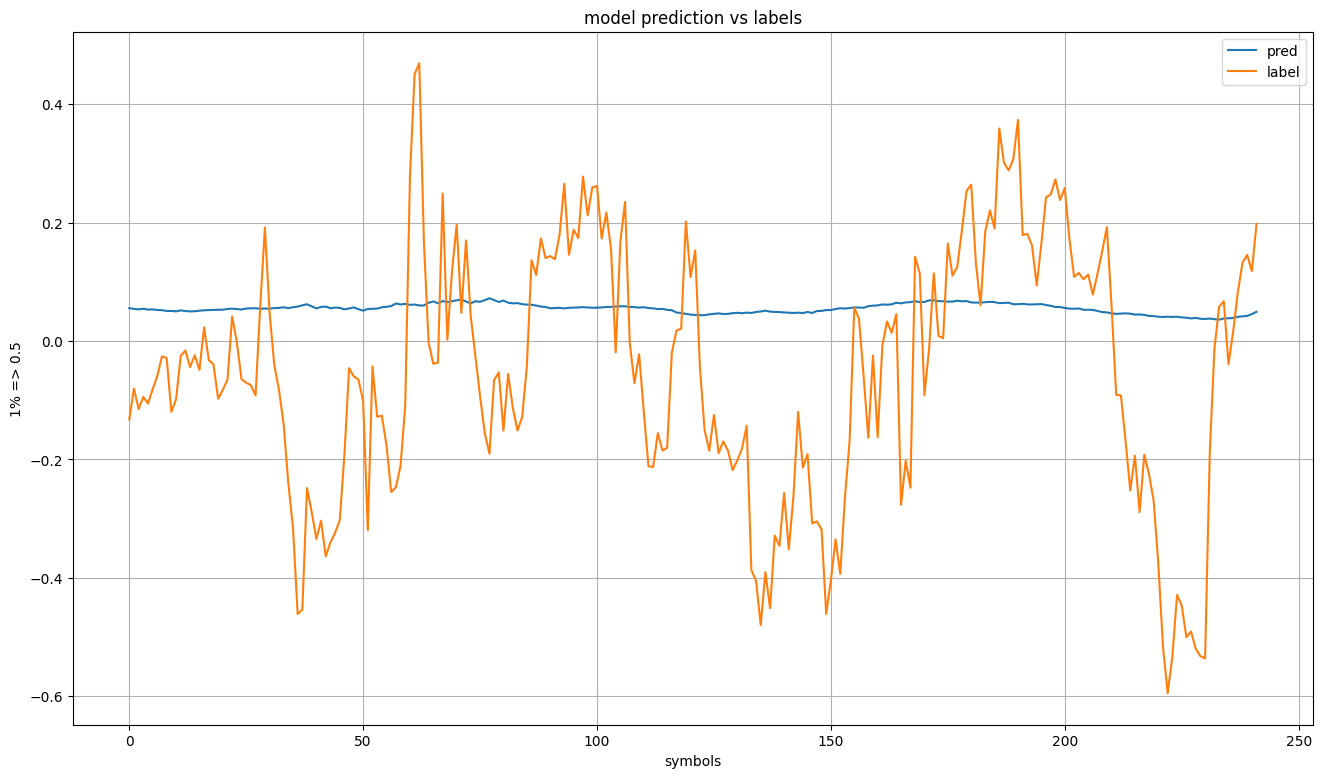

In [20]:
from matplotlib import pyplot as plt

# pred = model(x_v).to('cpu').detach().numpy()
# label = y_v.to('cpu').detach().numpy()

pred = model(x_t)
label = y_t

sym_index = np.arange(pred.shape[1])
plt.figure(figsize=(16, 9))
plt.title("model prediction vs labels")
plt.xlabel("symbols")
plt.ylabel("1% => 0.5")

plt.plot(pred, label="pred")
plt.plot(label, label="label")

plt.grid()
plt.legend()
plt.show()